# PreProcess Data

==>> M: [[ 0.54773835  0.41039339]
 [-1.64157357  0.50669901]]
==>> x_input: (8999, 2)
==>> x_label: (8999, 2)


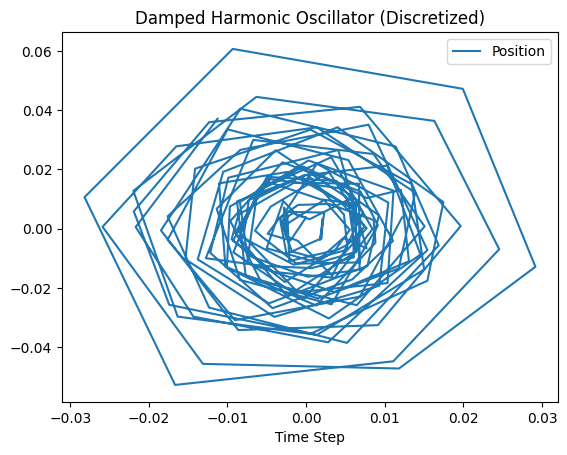

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.linalg import expm

def generate_damped_oscillator(M, B, C, T=10000, x0=None, seed=42):
    np.random.seed(seed)
    x_dim = M.shape[0]
    X = np.zeros((T, x_dim))
    X[0] = x0 if x0 is not None else np.random.randn(x_dim)

    for t in range(1, T):
        noise = np.random.randn(2)
        X[t] = M @ X[t - 1] + (B @ noise) + C
    return X

#Discretized setup
delta_t = 0.5  
M_continuous = np.array([
    [0.0, 1.0],
    [-4.0, -0.1]
])

M = expm(M_continuous * delta_t)
print(f"==>> M: {M}")

B = np.array([
    [0.0018, 0],
    [0.004645, 0.00363445]
]) 

#should be no constant forcing
C = np.array([0.0, 0.0])

X = generate_damped_oscillator(M, B, C, T=10000)

lead = 1 
transient = 1000   
x_input = X[transient:-lead]
print(f"==>> x_input: {x_input.shape}")
x_label = X[lead+transient:]
print(f"==>> x_label: {x_label.shape}")
#add the bias as a col to x_input
x_input = np.hstack([x_input, np.ones((x_input.shape[0], 1))])

plt.plot(X[transient:1200, 0], X[transient:transient+200, 1],  label="Position")
plt.legend()
plt.title("Damped Harmonic Oscillator (Discretized)")
plt.xlabel("Time Step")
plt.show()



# Find Linear Model Coeffecients

In [18]:
def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y)
    M = M_bias[:-1, :].T
    c = M_bias[-1:, :].T
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (residuals.shape[0] - 1)
    return M, c, BBT

# Determine Stationary Distribution

In [19]:
def stationary_distribution (M, c, BBT):
    mu = np.linalg.inv((np.eye(M.shape[0]) - M)) @ c
    gamma = scipy.linalg.solve_discrete_lyapunov(M, BBT)
    return mu, gamma

# Marginal Distributions

In [25]:

from scipy.stats import norm

def plot_marginal_distributions(feature_indices, mu, gamma, data):
    num_features = len(feature_indices)
    n_cols = 3  
    n_rows = (num_features + n_cols - 1) // n_cols  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, index in enumerate(feature_indices):
        mean = mu[index]
        std = np.sqrt(gamma[index, index])

        empirical_values = data[1000:, index]
        x = np.linspace(np.min(empirical_values), np.max(empirical_values), 500)

        pdf = norm.pdf(x, mean, std)
        print(f"Feature {index} | mu: {mean.item():.2f}, std: {std.item():.2f}, max PDF height: {pdf.max():.4f}")
        ax = axes[i]
        ax.hist(empirical_values, bins=100, density=True, alpha=0.5, label='Damped Oscillator Empirical', color='dodgerblue')
        ax.plot(x, pdf, color='green', label='Linear Model Gaussian')
        ax.set_title(f"Feature {index}")
        ax.set_xlabel("Value")
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Linear Model

BBT=array([[3.24000000e-06, 8.36100000e-06],
       [8.36100000e-06, 3.47852518e-05]])
BBT_fitted=array([[ 3.34866472e-06,  8.61407471e-06, -6.05282724e-09],
       [ 8.61407471e-06,  3.51246718e-05, -2.99121121e-08],
       [-6.05282724e-09, -2.99121121e-08,  3.60781930e-08]])
M_fitted=array([[ 5.46698083e-01,  4.11063090e-01, -6.19726722e-02],
       [-1.64881183e+00,  5.07996107e-01, -1.73510988e-01],
       [-6.24684438e-05,  3.70351739e-05,  3.08939769e-01]])
M=array([[ 0.54773835,  0.41039339],
       [-1.64157357,  0.50669901]])
c_fitted=array([[9.24619893e-06],
       [3.43365125e-05],
       [9.53730470e-05]])
Max |eigvals(M)| = 0.9753099120283328
Feature 0 | mu: 0.00, std: 0.01, max PDF height: 33.9253
Feature 1 | mu: 0.00, std: 0.02, max PDF height: 16.9425


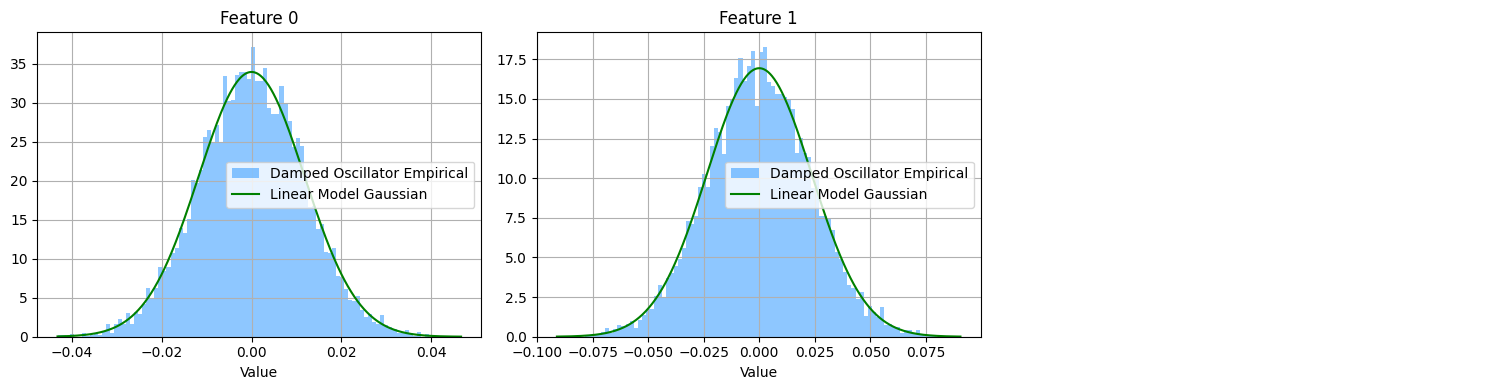

In [26]:
feature_indices = [0,1]
M_fitted, c_fitted, BBT_fitted = linear_model_coeffs(x_input, x_label)
BBT = B @ B.T
print(f"{BBT=}")
print(f"{BBT_fitted=}")
print(f"{M_fitted=}")
print(f"{M=}")
print(f"{c_fitted=}")
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M_fitted, c_fitted, BBT_fitted)
plot_marginal_distributions(feature_indices, mu, gamma, X)

# EDMD

==>> M: [[ 0.54773835  0.41039339]
 [-1.64157357  0.50669901]]
==>> X_aug.shape: (10000, 3)
==>> x_input: (8999, 3)
==>> x_label: (8999, 3)
Max |eigvals(M)| = 0.9753099120283328
Feature 0 | mu: 0.00, std: 0.01, max PDF height: 33.9253
Feature 1 | mu: 0.00, std: 0.02, max PDF height: 16.9425
Feature 2 | mu: 0.00, std: 0.00, max PDF height: 1997.5118


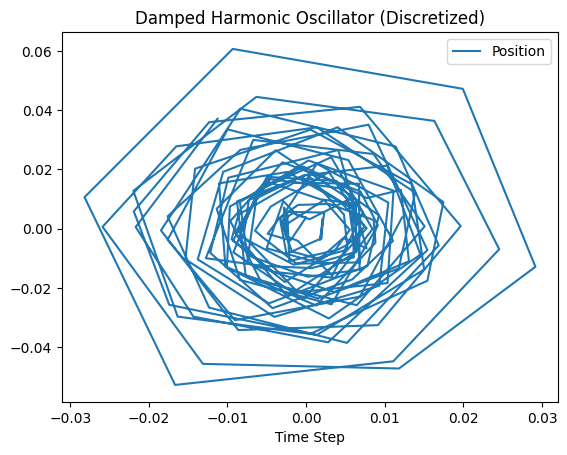

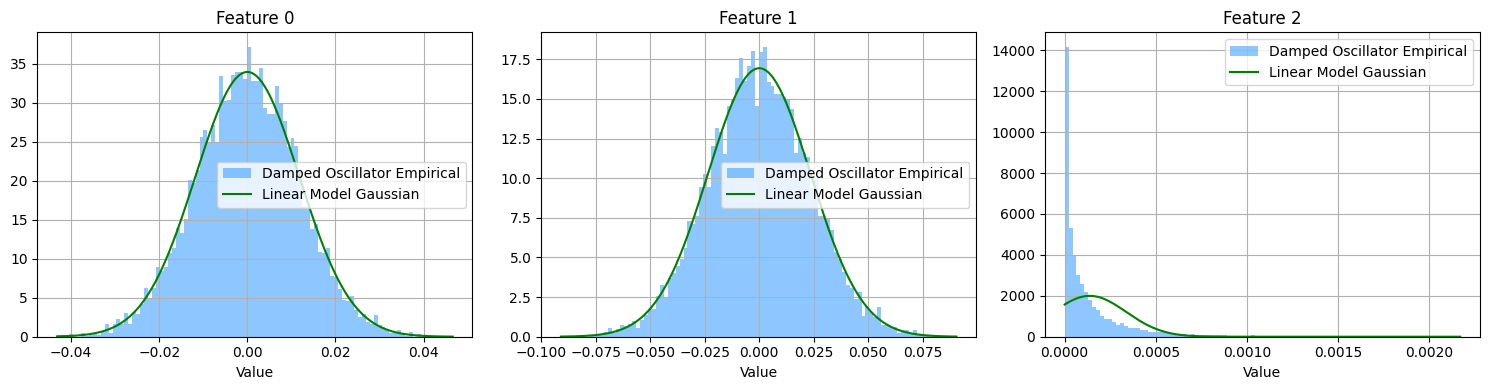

In [27]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.linalg import expm

def augment_with_quadratic(X):
    n_samples, n_features = X.shape
    n_aug = n_features + (n_features * (n_features - 1)) // 2 
    #initialize with bias
    X_aug = np.ones((n_samples, n_aug))  

    # Linear terms
    X_aug[:, :n_features] = X

    # Quadratic terms
    idx = n_features
    for i in range(n_features):
        for j in range(i, n_features):
            if (idx >= n_aug):
                break
            X_aug[:, idx] = X[:, i] * X[:, j]
            idx += 1

    print(f"==>> X_aug.shape: {X_aug.shape}")
    return X_aug

#Discretized setup
delta_t = 0.5  
M_continuous = np.array([
    [0.0, 1.0],
    [-4.0, -0.1]
])

M = expm(M_continuous * delta_t)
print(f"==>> M: {M}")

B = np.array([
    [0.0018, 0],
    [0.004645, 0.00363445]
]) 

#should be no constant forcing
C = np.array([0.0, 0.0])

X = generate_damped_oscillator(M, B, C, T=10000)

lead = 1 

#This will augment the data with quadratic features
damped_harmonic_oscillator = augment_with_quadratic(X)
transient = 1000   
x_input = damped_harmonic_oscillator[transient:-lead]
print(f"==>> x_input: {x_input.shape}")
x_label = damped_harmonic_oscillator[lead+transient:]
print(f"==>> x_label: {x_label.shape}")
#add the bias as a col to x_input
x_input = np.hstack([x_input, np.ones((x_input.shape[0], 1))])

plt.plot(X[transient:1200, 0], X[transient:transient+200, 1],  label="Position")
plt.legend()
plt.title("Damped Harmonic Oscillator (Discretized)")
plt.xlabel("Time Step")

def prepare_augmented_data(data_augmented, original_data, lead, bound, comparison_op):
    indices = np.where(comparison_op(original_data[:-1, 63], bound))[0]
    X = data_augmented[indices]
    Y = data_augmented[indices + lead]
    return X, Y, indices


def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y, rcond=None)
    M = M_bias[:-1, :].T
    c = M_bias[-1:, :].T
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (X.shape[0] - M_bias.shape[1])
    return M, c, BBT

def stationary_distribution(M, c, BBT):
    try:
        mu = np.linalg.inv((np.eye(M.shape[0]) - M)) @ c
        gamma = scipy.linalg.solve_discrete_lyapunov(M, BBT)
        return mu, gamma
    except np.linalg.LinAlgError:
        return mu, gamma

feature_indices = [0, 1, 2] 
M_fitted, c_fitted, BBT_fitted = linear_model_coeffs(x_input, x_label)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M_fitted, c_fitted, BBT_fitted)
plot_marginal_distributions(feature_indices, mu, gamma, damped_harmonic_oscillator)